This notebook incorporates the WhiteNoise kernel to produce error bar charts and parity plots per round. This is based on helpful discussions with Jaron Thompson on 8-01-24.

# Header Material

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
from src.models.constants import Constants
from src.models import util
from src.models.gaussian_process import featurize

In [4]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
df2 = pd.read_csv(processed_dir+"/"+"2-cleanedup_Round8-Standardized.csv")
print(df2.shape)
df2.head()

(12, 6)


,Pt1Sn3.5Fe2Ca2.5,Pt1Sn4Fe1.5Ca2.5,Pt1Sn4Fe2Ca2,Pt1Sn3.5Fe1.5Ca2.5,Pt1Sn3.5Fe1.5Ca3,Pt1Sn4Fe2Ca2.5
0,NaN,NaN,NaN,NaN,NaN,NaN
1,Pt1Sn3.5Fe2Ca2.5,Pt1Sn4Fe1.5Ca2.5,Pt1Sn4Fe2Ca2,Pt1Sn3.5Fe1.5Ca2.5,Pt1Sn3.5Fe1.5Ca3,Pt1Sn4Fe2Ca2.5
2,24-034,24-034,24-034,24-034,24-034,24-034
3,NaN,NaN,NaN,NaN,NaN,NaN
4,Pt1Sn3Cu2Ca3.5,Pt1Sn3Ga0.5Fe0.5Cu2.5Ca3.5,Pt1Sn2.5Fe0.5Cu1.5Ca3,Pt1Sn3Ga0.5Fe0.5Cu3Ca3.5,Pt1Sn3Ga0.5Fe0.5Cu3Ca5,Pt1Sn2Fe2Ca3


In [43]:
Sets = {"Training":["005","006","007","008","009","010","011","015","016"],
        "Round 1":["005","006","007","008","009","010","011","015","016","023"],
       "Round 2":["005","006","007","008","009","010","011","015","016","023","025"],
       "Round 3":["005","006","007","008","009","010","011","015","016","023","025","030"],
       "Round 4":["005","006","007","008","009","010","011","015","016","023","025","030","031"],
        "Round 5 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034"],
        "Round 6 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","038"],
        "Round 5 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035"],
        "Round 6 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035","049"],
        "Pre-Round 7":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061"],
        "Round 7":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061","064"]}


# Round by Round Parity Plots and $r^2$
Let's use a white kernel to estimate noise (see: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py for a good example). To do this, we will include tube that a catalyst was tested in as a variable.

In [5]:
def remove_duplicates(X_train,X_test,y_train,y_test,verbose=False,duplicate_if_different_tubes=True):
    idx_to_remove = []
    for i in range(X_test.shape[0]): #for each test datapoint:
        for j in range(X_train.shape[0]):
            if duplicate_if_different_tubes: #if same cat tested in diff tubes consider this a duplicate
                n=1
            else:
                n=0
            if np.array_equal(X_test[i,n:],X_train[j,n:]):
                if verbose:
                    print("Found equal")
                    print(X_test[i,:])
                    print(X_train[j,:])
                idx_to_remove.append(j)
    return np.delete(X_train,idx_to_remove,axis=0),np.delete(y_train,idx_to_remove,axis=0)

In [44]:
df2['Reaction'] = df2['Reaction'].str.replace('24-','')
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
header=["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
vals = {}
for name,rxns in Sets.items():
    df_sel = df2[df2["Reaction"].isin(rxns)]

    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
    print(name,rxns,X.shape)
    n = X.shape[0]
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries
        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
        pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
        pipeline.fit(X_train,y_train)
        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
        y_preds.append(y_pred[0])
        y_stds.append(y_pred_std[0])
        y_actuals.append(y_test[0])

    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)
    vals[name] = {"pred":pred,"expt":expt}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm
    print(label)


Training ['005', '006', '007', '008', '009', '010', '011', '015', '016'] (40, 8)
Training Norm_MAE 0.656 Norm_RMSE 0.359 R2: 0.633
Round 1 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023'] (46, 8)
Round 1 Norm_MAE 0.647 Norm_RMSE 0.361 R2: 0.555
Round 2 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025'] (52, 8)
Round 2 Norm_MAE 0.515 Norm_RMSE 0.297 R2: 0.656
Round 3 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030'] (58, 8)
Round 3 Norm_MAE 0.514 Norm_RMSE 0.318 R2: 0.573
Round 4 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031'] (64, 8)
Round 4 Norm_MAE 0.481 Norm_RMSE 0.299 R2: 0.577
Round 5 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034'] (70, 8)
Round 5 GP Norm_MAE 0.424 Norm_RMSE 0.268 R2: 0.625
Round 6 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034', '03

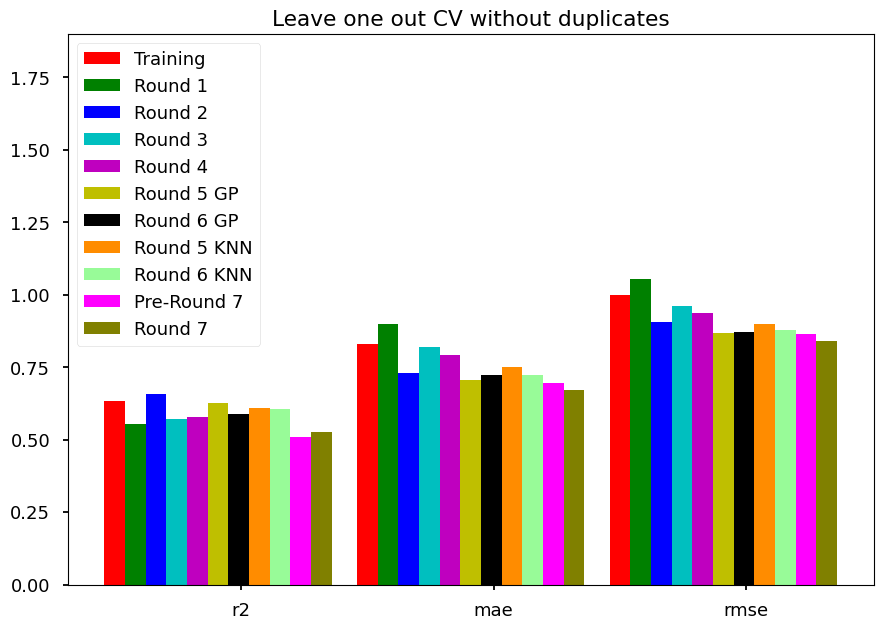

In [45]:
width =0.9/len(vals.keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV without duplicates")
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.show()
#plt.savefig("./figures/LOO-CV No Duplicates Through Round 7.png",dpi=600,bbox_inches='tight')



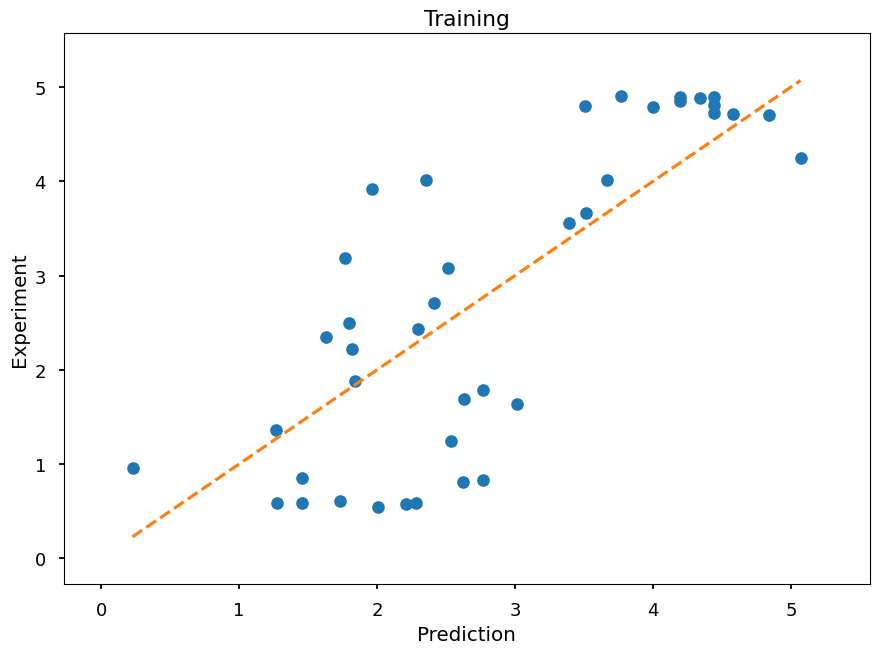

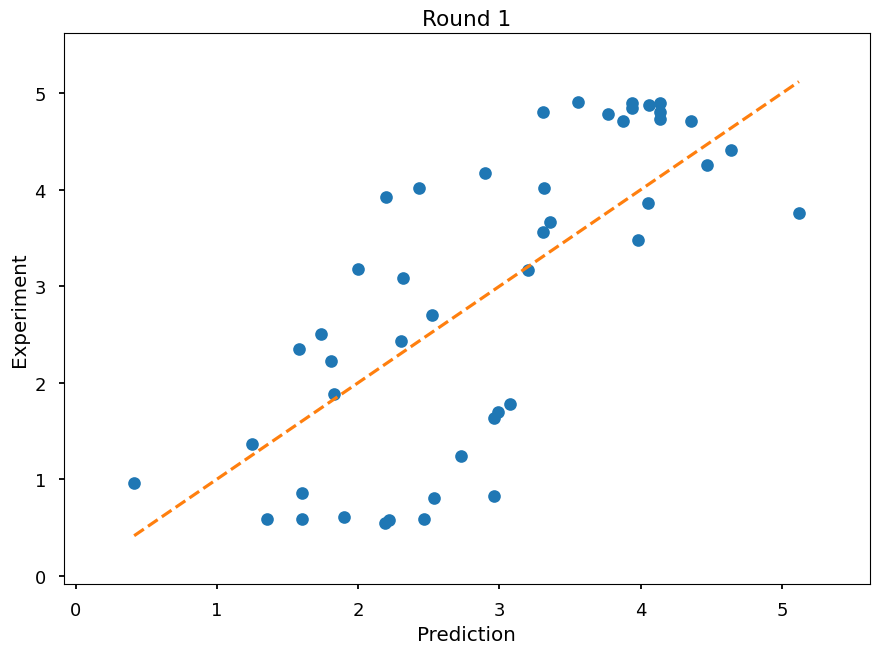

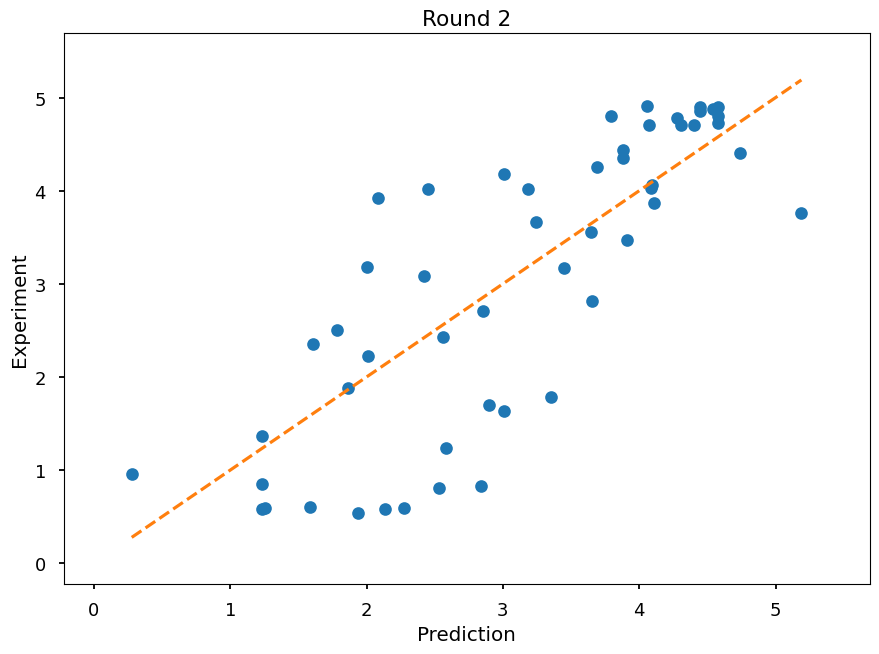

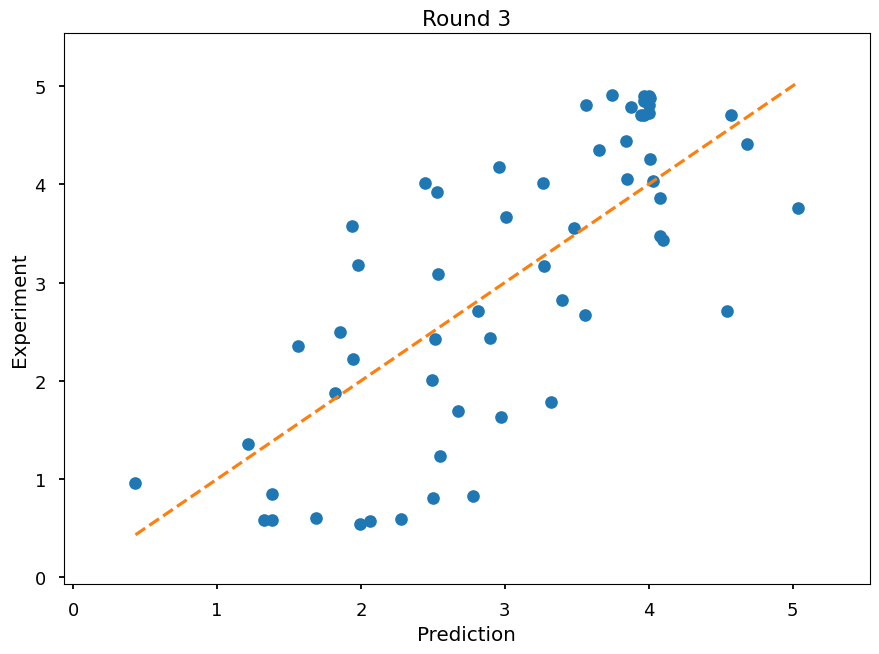

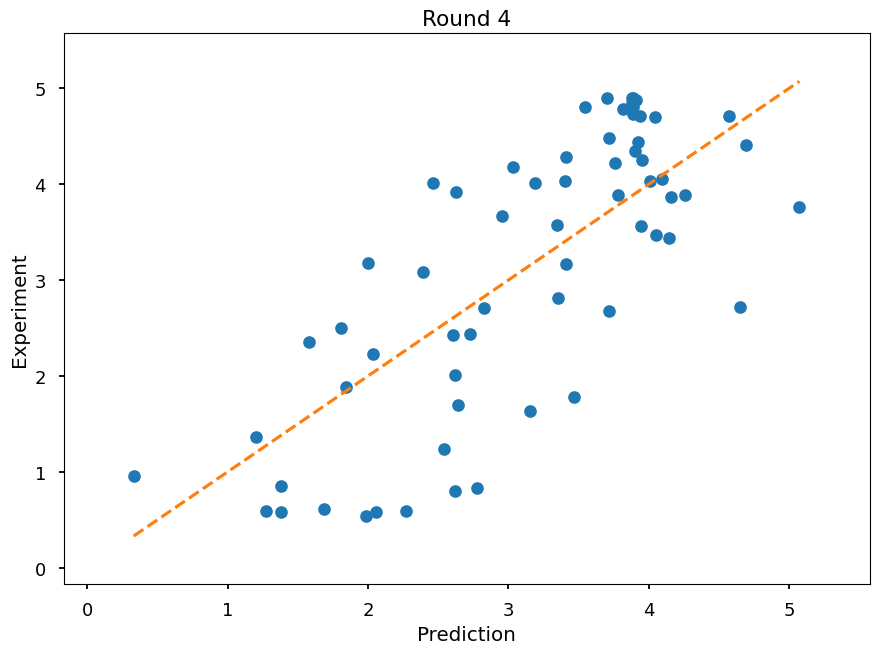

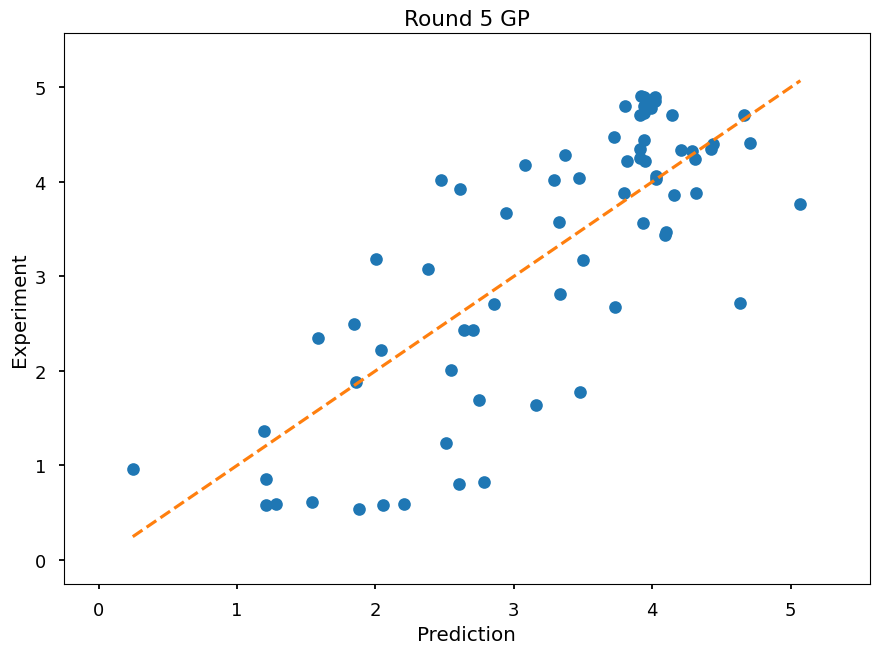

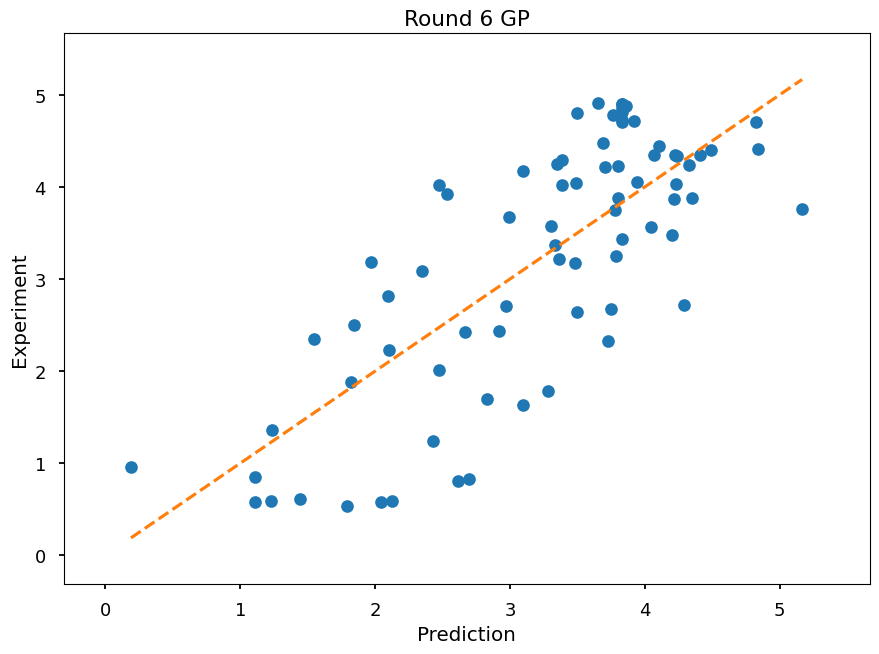

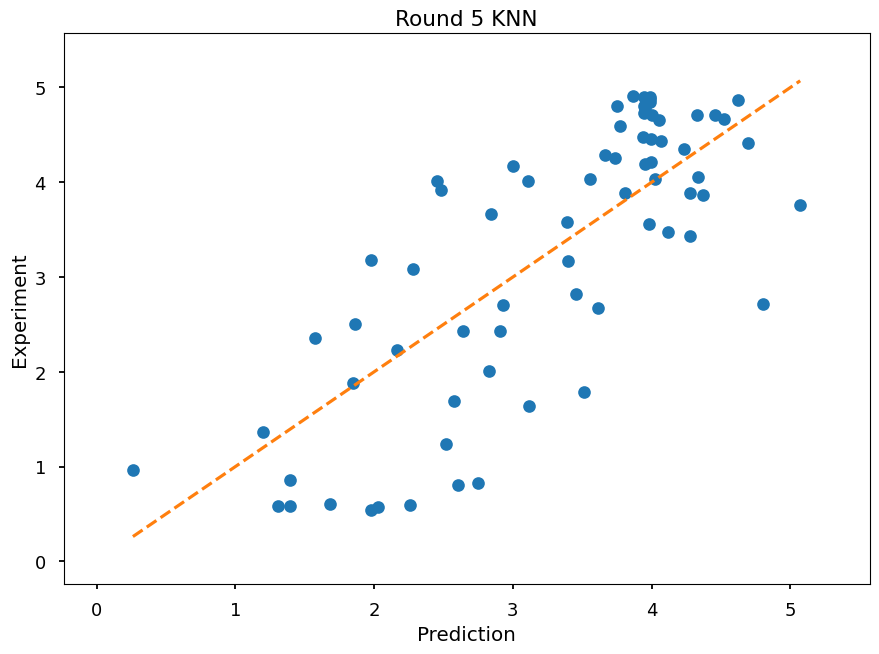

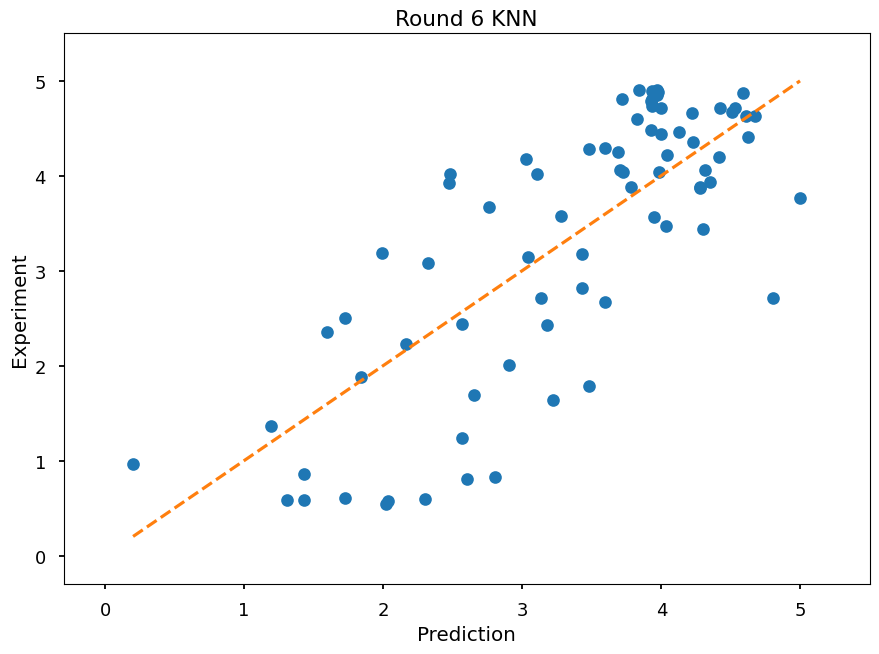

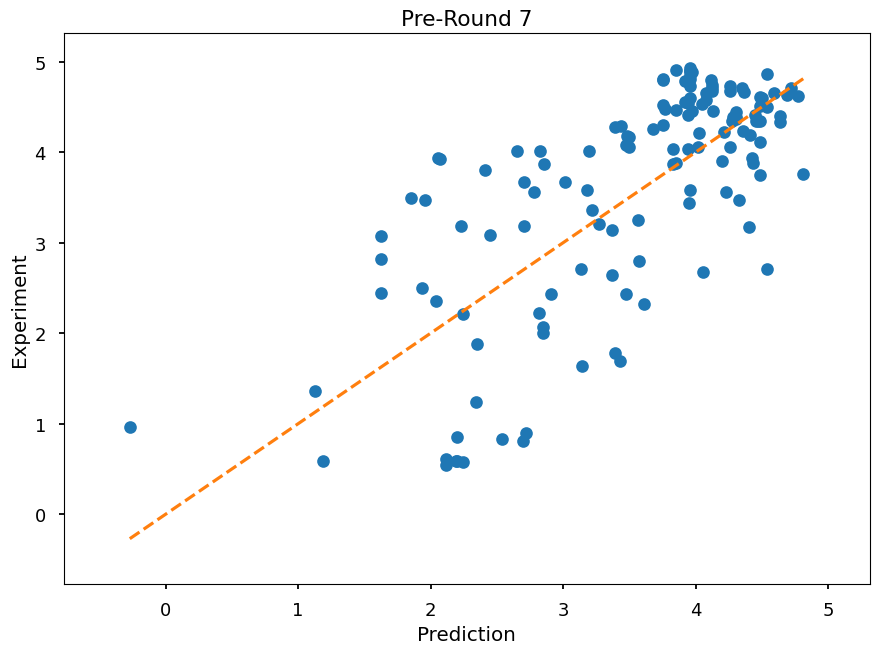

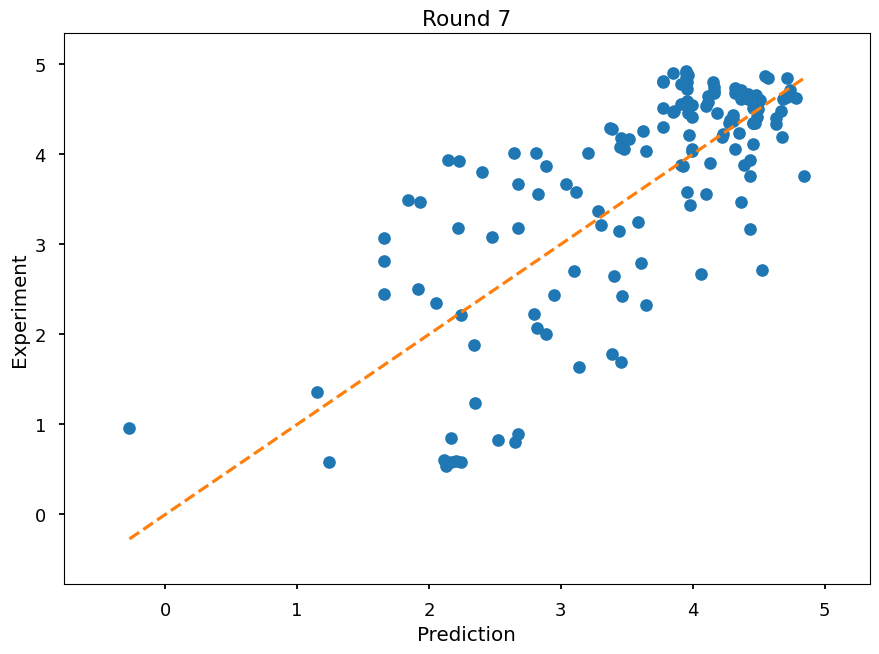

In [46]:
for name,pred_expt in vals.items():
    pred = pred_expt["pred"]
    expt=pred_expt["expt"]
    plt.plot(pred, expt, 'o')
    # plt.plot(y_preds,y_actuals,'o')
    plt.plot([min(pred),max(pred)],[min(pred),max(pred)],'--')
    plt.xlabel("Prediction")
    plt.ylabel("Experiment")
    plt.xlim((min(pred)-.5,max(pred)+.5))
    plt.ylim((min(pred)-.5,max(pred)+.5))
    plt.title(name)
    plt.show()

In [9]:
#Training Dataset r2
X = df2[header].to_numpy()
y = df2["sqrtY0Y_pc"].to_numpy()
kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
pipeline.fit(X,y)
r2_train=pipeline.score(X,y)
means,sds = pipeline.predict(X,return_std=True)
print(f'r2 of LOO-CV: {r2:.3} r2 of Training Data: {r2_train:.3}')

r2 of LOO-CV: 0.57 r2 of Training Data: 0.899


# Outlier analysis

On the parity plots there are some points with higher predicted score than experimental score. Let's try and understand what these catalysts are.

In [24]:
chosen_set = "Round 7"
df_arb = df_sel.loc[:,["Catalyst","Reaction","sqrtY0Y_pc"]]
df_arb.loc[:,"pred"]=vals[chosen_set]["pred"]
df_arb.loc[:,"expt"]=vals[chosen_set]["expt"]
df_arb["abs_delta"] = np.abs(df_arb["pred"]-df_arb["expt"])
#df_arb.sort_values("abs_delta",ascending=False).head(n=50)
df_arb.sort_values("pred").head(n=50)

,Catalyst,Reaction,sqrtY0Y_pc,pred,expt,abs_delta
38,Pt1Ga8,016,0.961565,-0.261632,0.961565,1.223197
19,Pt1Ga4Fe4/Al2O3,009,1.362025,1.354734,1.362025,0.007291
34,Pt1Fe8,015,0.587823,1.359581,0.587823,0.771758
33,Pt1Fe4,015,2.500355,1.886840,2.500355,0.613516
129,Pt1Ga1,058,3.490341,1.912584,3.490341,1.577757
133,Pt1Fe4,061,3.472052,1.932741,3.472052,1.539311
3,Pt1/γ-Al2O3 2/5/24,005,0.540875,2.026883,0.540875,1.486007
130,Pt1Cu8,061,3.939433,2.030067,3.939433,1.909366
36,Pt1Ga1,016,3.181161,2.034972,3.181161,1.146190
4,Pt1/γ-Al2O3 2/5/24,005,0.608945,2.045079,0.608945,1.436135


In [31]:
num_training_catalysts = vals["Training"]["pred"].shape[0]
df_arb = df_sel.loc[:num_training_catalysts,["Catalyst","Reaction","sqrtY0Y_pc"]]
for name in Sets.keys():
    df_arb.loc[:num_training_catalysts,f'pred_{name}']=vals[name]["pred"][:num_training_catalysts]
    #df_arb.sort_values("abs_delta",ascending=False).head(n=50)
df_arb.sort_values('sqrtY0Y_pc').head(n=50)

,Catalyst,Reaction,sqrtY0Y_pc,pred_Training,pred_Round 1,pred_Round 2,pred_Round 3,pred_Round 4,pred_Round 5 GP,pred_Round 6 GP,pred_Round 5 KNN,pred_Round 6 KNN,pred_Pre-Round 7,pred_Round 7
3,Pt1/γ-Al2O3 2/5/24,005,0.540875,2.008763,2.189385,1.719659,2.115843,2.060163,1.573400,1.647851,1.939184,2.039674,2.037262,2.026883
24,Pt1Ca1/Al2O3,010,0.577835,2.207145,2.218237,2.138990,2.249900,2.061515,2.073971,2.067784,2.026028,1.989129,2.293698,2.295595
28,Pt1/γ-Al2O3,011,0.584978,1.457111,1.603278,1.043625,1.641090,1.593068,0.838914,0.898351,1.494768,1.600786,2.087192,2.098095
34,Pt1Fe8,015,0.587823,1.275038,1.356892,1.222352,1.410479,1.271996,1.312504,1.290095,1.255881,1.330260,1.337756,1.359581
2,Pt1/γ-Al2O3 2/5/24,005,0.590604,2.279657,2.468771,2.055109,2.346126,2.285502,2.285324,2.405390,2.158870,2.255149,2.062183,2.046505
4,Pt1/γ-Al2O3 2/5/24,005,0.608945,1.731818,1.898205,1.377396,1.878700,1.827366,1.078656,1.131900,1.715713,1.819737,2.046460,2.045079
18,Pt1Ga4Cu4/Al2O3,009,0.805192,2.622840,2.534583,2.527654,2.480133,2.599872,2.587002,2.578455,2.556054,2.571334,2.605257,2.596223
0,Pt1/γ-Al2O3 2/5/24,005,0.827439,2.769157,2.960743,2.642394,2.759948,2.689773,3.844515,4.035947,2.560159,2.649977,2.202253,2.187614
5,Pt1/γ-Al2O3 2/5/24,005,0.853456,1.457111,1.603278,1.043625,1.641090,1.593068,0.838914,0.898351,1.494768,1.600786,2.087192,2.098095
38,Pt1Ga8,016,0.961565,0.226844,0.413114,0.114018,0.459616,0.278221,0.227010,0.079908,0.216916,0.234875,-0.241753,-0.261632


# Testing $r^2$ on the same set of catalysts

Another reasonable question might be: how much of the reducing r2 is coming from new data vs improved performance on previous data. Let's test this by plotting r2, etc. on just the training set catalysts.

Training Norm_MAE 0.656 Norm_RMSE 0.359 R2: 0.633
Round 1 Norm_MAE 0.721 Norm_RMSE 0.39 R2: 0.582
Round 2 Norm_MAE 0.628 Norm_RMSE 0.347 R2: 0.662
Round 3 Norm_MAE 0.656 Norm_RMSE 0.363 R2: 0.657
Round 4 Norm_MAE 0.668 Norm_RMSE 0.375 R2: 0.625
Round 5 GP Norm_MAE 0.638 Norm_RMSE 0.36 R2: 0.649
Round 6 GP Norm_MAE 0.627 Norm_RMSE 0.371 R2: 0.629
Round 5 KNN Norm_MAE 0.665 Norm_RMSE 0.369 R2: 0.633
Round 6 KNN Norm_MAE 0.683 Norm_RMSE 0.377 R2: 0.612
Pre-Round 7 Norm_MAE 0.777 Norm_RMSE 0.403 R2: 0.547
Round 7 Norm_MAE 0.775 Norm_RMSE 0.4 R2: 0.557


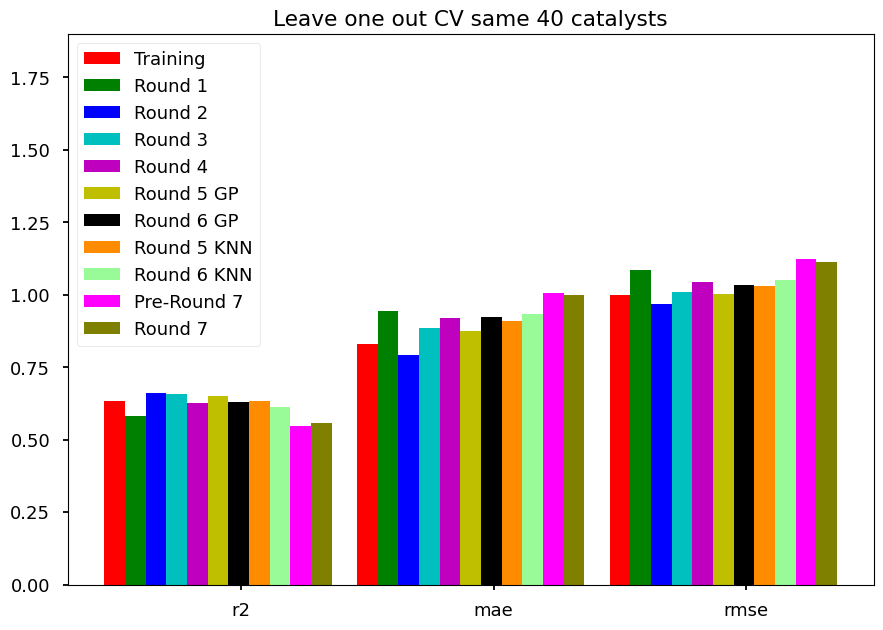

In [47]:
num_training_catalysts = vals["Training"]["pred"].shape[0]
res_same_tests = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
set_names = Sets.keys()

for name in set_names:
    pred = vals[name]["pred"][0:num_training_catalysts]
    expt = vals[name]["expt"][0:num_training_catalysts]
    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res_same_tests["rmse"][name]=rmse
    res_same_tests["r2"][name]=r2
    res_same_tests["mae_norm"][name]=mae_norm
    res_same_tests["mae"][name]=mae
    res_same_tests["rmse_norm"][name]=rmse_norm
    print(label)
    
width =0.9/len(res_same_tests["r2"].keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res_same_tests['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res_same_tests[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res_same_tests[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV same {} catalysts".format(num_training_catalysts))
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.show()
#plt.savefig("./figures/LOO-CV No Duplicates Through Round 7.png",dpi=600,bbox_inches='tight')




# Comparison to no white kernel

What happens if we neglect the noise kernel? Does r2 go up?

In [48]:
df2['Reaction'] = df2['Reaction'].str.replace('24-','')
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
header=["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
vals = {}
for name,rxns in Sets.items():
    df_sel = df2[df2["Reaction"].isin(rxns)]

    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
    print(name,rxns,X.shape)
    n = X.shape[0]
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries
        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))
        pipeline = make_pipeline(GaussianProcessRegressor(alpha=0.01,kernel=kernel,n_restarts_optimizer=5,random_state=seed))
        pipeline.fit(X_train,y_train)
        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
        y_preds.append(y_pred[0])
        y_stds.append(y_pred_std[0])
        y_actuals.append(y_test[0])

    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)
    vals[name] = {"pred":pred,"expt":expt}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm
    print(label)


Training ['005', '006', '007', '008', '009', '010', '011', '015', '016'] (40, 8)
Training Norm_MAE 0.648 Norm_RMSE 0.507 R2: 0.343
Round 1 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023'] (46, 8)
Round 1 Norm_MAE 0.511 Norm_RMSE 0.422 R2: 0.462
Round 2 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025'] (52, 8)
Round 2 Norm_MAE 0.392 Norm_RMSE 0.278 R2: 0.698
Round 3 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030'] (58, 8)
Round 3 Norm_MAE 0.414 Norm_RMSE 0.326 R2: 0.564
Round 4 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031'] (64, 8)
Round 4 Norm_MAE 0.402 Norm_RMSE 0.294 R2: 0.595
Round 5 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034'] (70, 8)
Round 5 GP Norm_MAE 0.384 Norm_RMSE 0.283 R2: 0.588
Round 6 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034', '03

D:\ukuru\anaconda3\envs\ml-env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\ukuru\anaconda3\envs\ml-env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\ukuru\anaconda3\envs\ml-env\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Round 7 Norm_MAE 0.346 Norm_RMSE 0.268 R2: 0.438


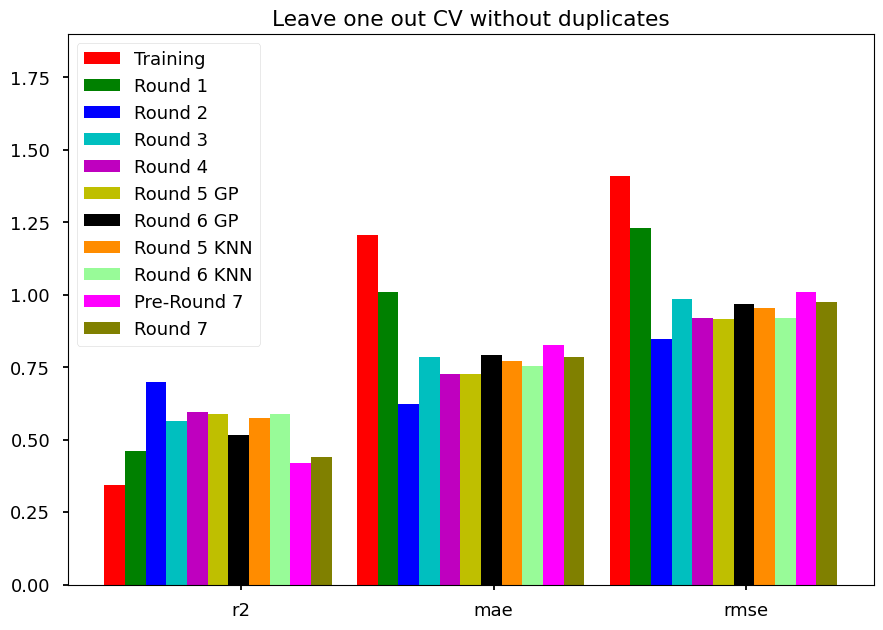

Training Norm_MAE 0.648 Norm_RMSE 0.507 R2: 0.343
Round 1 Norm_MAE 0.569 Norm_RMSE 0.469 R2: 0.469
Round 2 Norm_MAE 0.488 Norm_RMSE 0.34 R2: 0.667
Round 3 Norm_MAE 0.509 Norm_RMSE 0.368 R2: 0.633
Round 4 Norm_MAE 0.552 Norm_RMSE 0.373 R2: 0.609
Round 5 GP Norm_MAE 0.568 Norm_RMSE 0.387 R2: 0.584
Round 6 GP Norm_MAE 0.585 Norm_RMSE 0.412 R2: 0.542
Round 5 KNN Norm_MAE 0.542 Norm_RMSE 0.4 R2: 0.579
Round 6 KNN Norm_MAE 0.535 Norm_RMSE 0.386 R2: 0.6
Pre-Round 7 Norm_MAE 0.733 Norm_RMSE 0.445 R2: 0.449
Round 7 Norm_MAE 0.739 Norm_RMSE 0.44 R2: 0.456


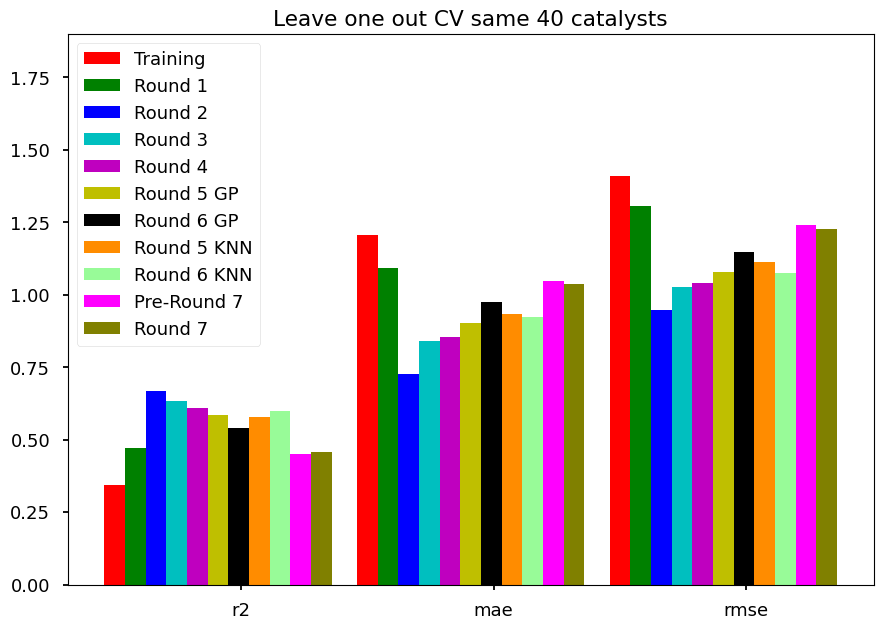

In [49]:
width =0.9/len(vals.keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV without duplicates")
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.show()
#plt.savefig("./figures/LOO-CV No Duplicates Through Round 7.png",dpi=600,bbox_inches='tight')

num_training_catalysts = vals["Training"]["pred"].shape[0]
res_same_tests = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
set_names = Sets.keys()

for name in set_names:
    pred = vals[name]["pred"][0:num_training_catalysts]
    expt = vals[name]["expt"][0:num_training_catalysts]
    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res_same_tests["rmse"][name]=rmse
    res_same_tests["r2"][name]=r2
    res_same_tests["mae_norm"][name]=mae_norm
    res_same_tests["mae"][name]=mae
    res_same_tests["rmse_norm"][name]=rmse_norm
    print(label)
    
width =0.9/len(res_same_tests["r2"].keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res_same_tests['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res_same_tests[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res_same_tests[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV same {} catalysts".format(num_training_catalysts))
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.show()
#plt.savefig("./figures/LOO-CV No Duplicates Through Round 7.png",dpi=600,bbox_inches='tight')




# Does scaling the data improve anything?

In [50]:
df2['Reaction'] = df2['Reaction'].str.replace('24-','')
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
header=["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]

res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
vals = {}
for name,rxns in Sets.items():
    df_sel = df2[df2["Reaction"].isin(rxns)]

    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
    print(name,rxns,X.shape)
    n = X.shape[0]
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test) #avoid leakage by removing identical entries
        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
        pipeline = make_pipeline(StandardScaler(),GaussianProcessRegressor(normalize_y=True,kernel=kernel,n_restarts_optimizer=5,random_state=seed))
        pipeline.fit(X_train,y_train)
        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
        y_preds.append(y_pred[0])
        y_stds.append(y_pred_std[0])
        y_actuals.append(y_test[0])

    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)
    vals[name] = {"pred":pred,"expt":expt}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm
    print(label)


Training ['005', '006', '007', '008', '009', '010', '011', '015', '016'] (40, 8)
Training Norm_MAE 1.07 Norm_RMSE 0.515 R2: 0.252
Round 1 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023'] (46, 8)
Round 1 Norm_MAE 0.892 Norm_RMSE 0.458 R2: 0.284
Round 2 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025'] (52, 8)
Round 2 Norm_MAE 0.77 Norm_RMSE 0.384 R2: 0.464
Round 3 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030'] (58, 8)
Round 3 Norm_MAE 0.762 Norm_RMSE 0.404 R2: 0.344
Round 4 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031'] (64, 8)
Round 4 Norm_MAE 0.717 Norm_RMSE 0.385 R2: 0.327
Round 5 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034'] (70, 8)
Round 5 GP Norm_MAE 0.666 Norm_RMSE 0.359 R2: 0.352
Round 6 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023', '025', '030', '031', '034', '038'

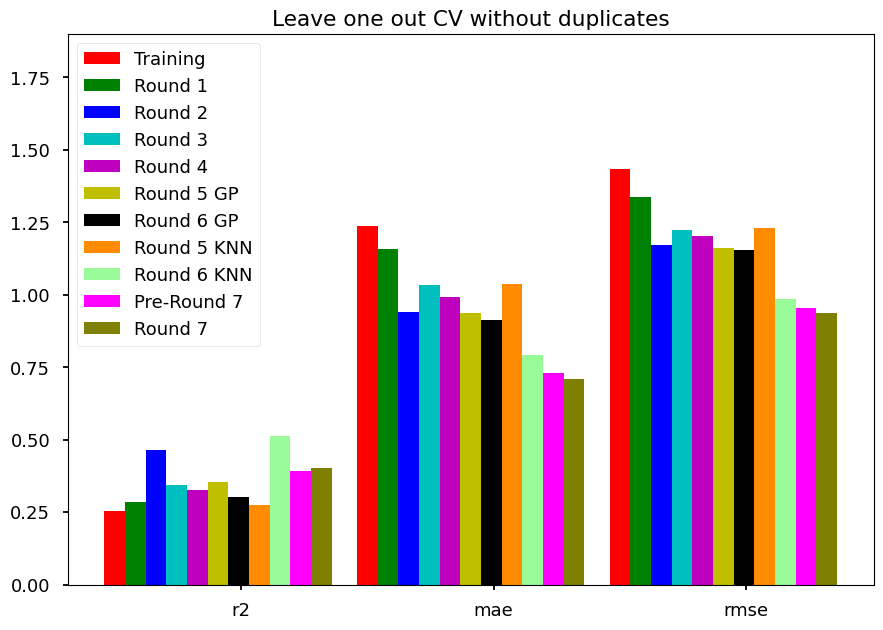

Training Norm_MAE 1.07 Norm_RMSE 0.515 R2: 0.252
Round 1 Norm_MAE 1.01 Norm_RMSE 0.512 R2: 0.252
Round 2 Norm_MAE 0.971 Norm_RMSE 0.469 R2: 0.417
Round 3 Norm_MAE 1.02 Norm_RMSE 0.498 R2: 0.337
Round 4 Norm_MAE 1.04 Norm_RMSE 0.512 R2: 0.287
Round 5 GP Norm_MAE 1.05 Norm_RMSE 0.515 R2: 0.273
Round 6 GP Norm_MAE 1.07 Norm_RMSE 0.533 R2: 0.212
Round 5 KNN Norm_MAE 1.09 Norm_RMSE 0.537 R2: 0.187
Round 6 KNN Norm_MAE 0.832 Norm_RMSE 0.439 R2: 0.464
Pre-Round 7 Norm_MAE 1.03 Norm_RMSE 0.496 R2: 0.37
Round 7 Norm_MAE 1.03 Norm_RMSE 0.498 R2: 0.359


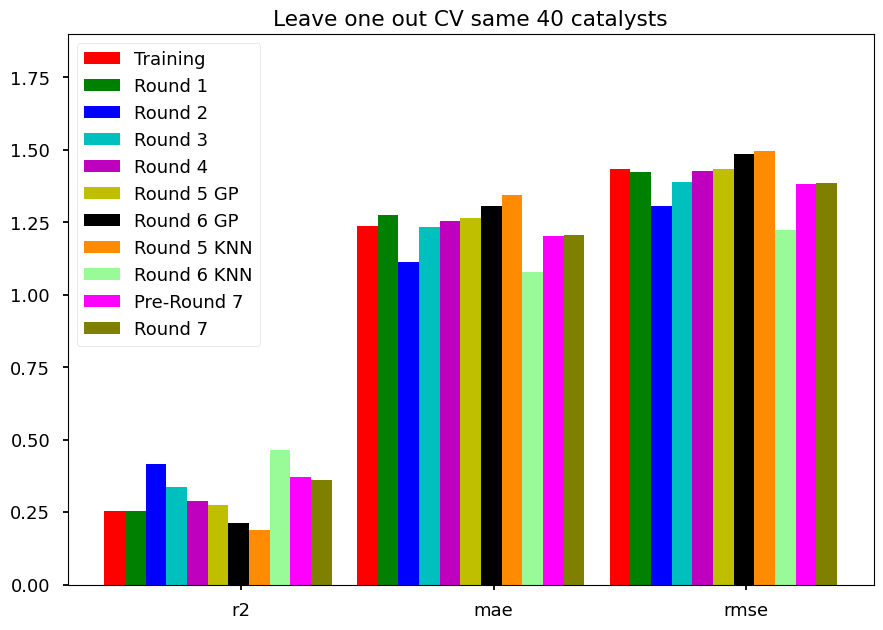

In [51]:
width =0.9/len(vals.keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV without duplicates")
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.show()
#plt.savefig("./figures/LOO-CV No Duplicates Through Round 7.png",dpi=600,bbox_inches='tight')

num_training_catalysts = vals["Training"]["pred"].shape[0]
res_same_tests = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
set_names = Sets.keys()

for name in set_names:
    pred = vals[name]["pred"][0:num_training_catalysts]
    expt = vals[name]["expt"][0:num_training_catalysts]
    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res_same_tests["rmse"][name]=rmse
    res_same_tests["r2"][name]=r2
    res_same_tests["mae_norm"][name]=mae_norm
    res_same_tests["mae"][name]=mae
    res_same_tests["rmse_norm"][name]=rmse_norm
    print(label)
    
width =0.9/len(res_same_tests["r2"].keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res_same_tests['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res_same_tests[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res_same_tests[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV same {} catalysts".format(num_training_catalysts))
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.show()
#plt.savefig("./figures/LOO-CV No Duplicates Through Round 7.png",dpi=600,bbox_inches='tight')




# Round by Round bar chart without leaving out duplicates if they're tested in different tubes

In [54]:
df2['Reaction'] = df2['Reaction'].str.replace('24-','')
df2["diversity"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].astype(bool).sum(axis=1)
df2["loading"] = df2[["Pt","Sn","Ga","Fe","Cu","Ca"]].sum(axis=1)
header=["Tube","Sn","Ga","Fe","Cu","Ca","diversity","loading"]
res = {"mae":{},"r2":{},"mae_norm":{},"rmse":{},"rmse_norm":{}}
vals = {}
for name,rxns in Sets.items():
    df_sel = df2[df2["Reaction"].isin(rxns)]

    X = df_sel[header].to_numpy()
    y = df_sel["sqrtY0Y_pc"].to_numpy()
    print(name,rxns,X.shape)
    n = X.shape[0]
    y_preds = []
    y_stds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train,y_train = remove_duplicates(X_train,X_test,y_train,y_test,duplicate_if_different_tubes=False) #avoid leakage by removing identical entries
        kernel = 1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))+kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
        pipeline = make_pipeline(GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5,random_state=seed))
        pipeline.fit(X_train,y_train)
        y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
        y_preds.append(y_pred[0])
        y_stds.append(y_pred_std[0])
        y_actuals.append(y_test[0])

    pred = np.asarray(y_preds)
    expt = np.asarray(y_actuals)
    vals[name] = {"pred":pred,"expt":expt}



    mae = np.mean(np.abs(pred-expt))
    slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
    r2 = r_value**2
    rmse = np.sqrt(mean_squared_error(expt,pred))
    mae_norm = np.mean(np.abs(pred-expt)/expt)
    rmse_norm = rmse / np.mean(expt)
    label=f'{name} Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
    res["rmse"][name]=rmse
    res["r2"][name]=r2
    res["mae_norm"][name]=mae_norm
    res["mae"][name]=mae
    res["rmse_norm"][name]=rmse_norm
    print(label)


Training ['005', '006', '007', '008', '009', '010', '011', '015', '016'] (40, 8)
Training Norm_MAE 0.418 Norm_RMSE 0.28 R2: 0.774
Round 1 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '023'] (46, 8)
Round 1 Norm_MAE 0.402 Norm_RMSE 0.272 R2: 0.744
Round 2 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '025'] (46, 8)
Round 2 Norm_MAE 0.364 Norm_RMSE 0.253 R2: 0.784
Round 3 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '030'] (46, 8)
Round 3 Norm_MAE 0.432 Norm_RMSE 0.303 R2: 0.699
Round 4 ['005', '006', '007', '008', '009', '010', '011', '015', '016', '030', '031'] (52, 8)
Round 4 Norm_MAE 0.38 Norm_RMSE 0.271 R2: 0.722
Round 5 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '030', '031', '034'] (58, 8)
Round 5 GP Norm_MAE 0.347 Norm_RMSE 0.246 R2: 0.742
Round 6 GP ['005', '006', '007', '008', '009', '010', '011', '015', '016', '030', '031', '034', '038'] (64, 8)
Round 6 GP Norm_MAE 0.327 Norm_RMSE 0.246 R2: 0.717
R

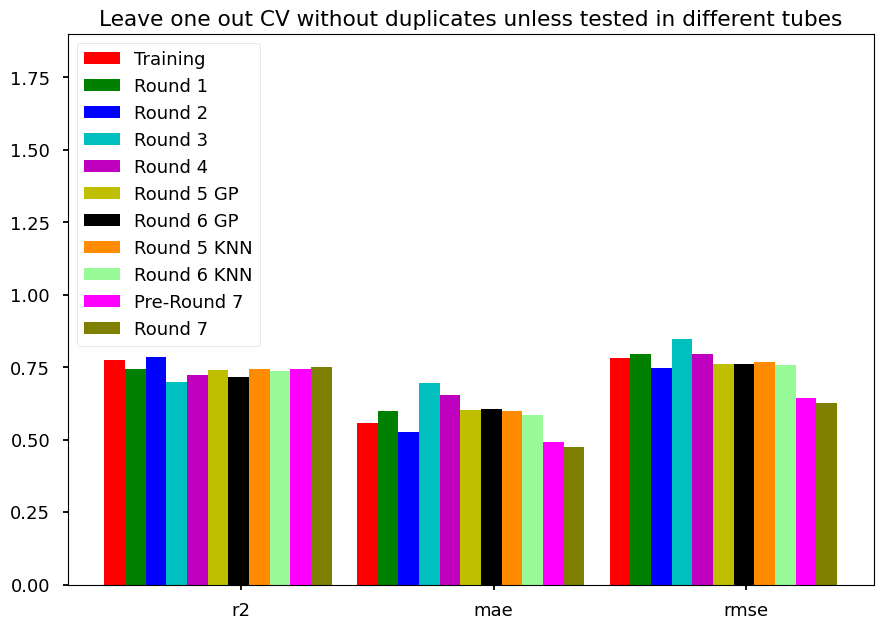

In [55]:
width =0.9/len(vals.keys())
scores = {"r2":0,"mae":1,"rmse":2}
names = res['r2'].keys() #names of various rounds
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['r2','mae','rmse']):
    for j,name in enumerate(names):
        if val == 'r2':
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j],label=name)
        else: #no label to prevent repeats
            ax.bar(scores[val]+j*width,res[val][name],width=width,color=color_list[j])
plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
plt.title("Leave one out CV without duplicates unless tested in different tubes")
plt.legend(loc='upper left')
plt.ylim((0,1.9))
plt.savefig("./figures/LOO-CV No Duplicates Unless Diff Tubes Through Round 7.png",dpi=600,bbox_inches='tight')

